In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src_fork/")
sys.path.insert(0,"../src_fork/analysis")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction


utils.plot_settings()  # LaTeX fonts in Plots!

FIGPATH = "../figs/"
FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

SEEDVAL = 2021

In [2]:
np.random.seed(SEEDVAL)
n = 200
noise_scale = 0.2
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
max_degree = 15
n_lambdas = 30
n_bootstraps = 100
k_folds = 5
lambdas = np.logspace(-5, 0, n_lambdas)
subset_lambdas = lambdas[::60]

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept

#   Centering the response
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

########### Setup of problem is completed above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Maybe not for ridge+lasso. Don't want to penalize constants...

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 #maybe not for ridge+lasso
    #    X_test_scaled[:,0] = 1 #maybe not for ridge+lasso

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree. Also, gets
    # ols_CV_MSE

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    # All regression bootstraps at once
    lamb_ridge = best_ridge_lambda[degree_index]
    lamb_lasso = best_lasso_lambda[degree_index]

    (
        ridge_mse,
        ridge_bias,
        ridge_variance,
        lasso_mse,
        lasso_bias,
        lasso_variance,
        ols_mse,
        ols_bias,
        ols_variance,
    ) = bootstrap.bootstrap_all(
        X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
    )

    (
        ridge_best_lambda_boot_mse[degree_index],
        ridge_best_lambda_boot_bias[degree_index],
        ridge_best_lambda_boot_variance[degree_index],
    ) = (ridge_mse, ridge_bias, ridge_variance)

    (
        lasso_best_lambda_boot_mse[degree_index],
        lasso_best_lambda_boot_bias[degree_index],
        lasso_best_lambda_boot_variance[degree_index],
    ) = (lasso_mse, lasso_bias, lasso_variance)

    ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
        ols_mse,
        ols_bias,
        ols_variance,
    )

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5157294014375102, tolerance: 0.0019017262091869597
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6620498470841962, tolerance: 0.0019602848512918266
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.413063713076707, tolerance: 0.0018649791486250625
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1559176312110946, tolerance: 0.0016459179686308088
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.275702141443428, tolerance: 0.0019089218000627316
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08962431341566468, tolerance: 0.001532960091793974
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6758877531540408, tolerance: 0.0016620907654057856
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2631512326070471, tolerance: 0.0015260007566217063
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16664798275768522, tolerance: 0.001980433768508497
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.409061007414516, tolerance: 0.001668669375799336
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.81268587270235, tolerance: 0.001900887824605448
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9742961343661873, tolerance: 0.001655892228264798
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.992192842705047, tolerance: 0.0016025273300156564
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6495714399025347, tolerance: 0.0019416140938543927
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0542966403491834, tolerance: 0.00199172792508216
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8900098158840786, tolerance: 0.0022606258514372107
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8477130804187443, tolerance: 0.001763026000205799
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2792127774279383, tolerance: 0.001751954786736787
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7055559333469068, tolerance: 0.0019586795412595585
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4144509708934514, tolerance: 0.0018129159413579662
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4179171421120742, tolerance: 0.0018094842202664417
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4286231056269347, tolerance: 0.001988946149946594
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9321191459868827, tolerance: 0.0018478976766689535
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7703245431445973, tolerance: 0.0018223448006953135
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.176362946460577, tolerance: 0.0023771347202974653
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0472914604541983, tolerance: 0.0016799900465103215
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1105185799501966, tolerance: 0.0013543985876297547
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7926339633520687, tolerance: 0.001791573302293546
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.04552890764397, tolerance: 0.0013970372319762198
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.647060236089396, tolerance: 0.0020292340128637044
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2374125767958568, tolerance: 0.001755170876721664
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.64739778856138, tolerance: 0.0017724771567435903
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8203475903357731, tolerance: 0.001912197416968379
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.38010960602141, tolerance: 0.001860352317669282
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.424175324042488, tolerance: 0.0017148888765831484
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9840855481002415, tolerance: 0.002224576702520532
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.693881984432712, tolerance: 0.001553873007759217
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4609454022899055, tolerance: 0.001731936765591631
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5509073748479603, tolerance: 0.0016938565864662743
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.690126342669856, tolerance: 0.0018475320936815547
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1784895449905948, tolerance: 0.0018937593865681365
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4355547036917646, tolerance: 0.0016875210773297938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.754626699618764, tolerance: 0.00188559181112801
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8542936133245456, tolerance: 0.0018140305152514308
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6723908866337887, tolerance: 0.001831133739514118
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.628657480522155, tolerance: 0.0018140305152514308
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8555499887725069, tolerance: 0.001831133739514118
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9140264967674754, tolerance: 0.0018776214926872186
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002338136128400947, tolerance: 0.00188559181112801
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.590908479437894, tolerance: 0.002409374320088179
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4749861064454586, tolerance: 0.002151477813488729
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2344391502975083, tolerance: 0.0016184301081039964
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4027020757506086, tolerance: 0.0017284608533703995
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9310236055101653, tolerance: 0.0021582430722903306
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2405688262943912, tolerance: 0.0019774798121731272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3719757091814717, tolerance: 0.0016550867986872507
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.783766372517103, tolerance: 0.002099067693014195
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8477430533782693, tolerance: 0.001989972852928103
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8491096764652486, tolerance: 0.0017771070167682717
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4805590874977865, tolerance: 0.0017910855649406984
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019403748560270273, tolerance: 0.001989972852928103
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015303734974696503, tolerance: 0.0017771070167682717
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076892914242474575, tolerance: 0.0017910855649406984
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5614747947306324, tolerance: 0.0017788279218049535
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.40694602543963, tolerance: 0.001808169789828265
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7176323679400969, tolerance: 0.0018319088366842188
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0228794822029332, tolerance: 0.0016600198314414524
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7247806586705823, tolerance: 0.0017952762427281622
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3136302770355912, tolerance: 0.001840871098366164
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4152815163519312, tolerance: 0.0016431944460985246
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8750483000090288, tolerance: 0.0019309222233202619
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.107231306737221, tolerance: 0.0020065122417446232
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003838492328504195, tolerance: 0.0019309222233202619
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004529648479811854, tolerance: 0.001938739026153713
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9653057695910108, tolerance: 0.001510217795778785
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4513061799770415, tolerance: 0.0018257583239590458
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4258128827161372, tolerance: 0.002044205744786212
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9810842260202166, tolerance: 0.0016393907129663397
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6892464171535648, tolerance: 0.0015359142685507103
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7723530750497751, tolerance: 0.002338906735290059
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0544548458304943, tolerance: 0.0017871655211831525
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7816782520945886, tolerance: 0.0018534323698562749
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8683839160052322, tolerance: 0.00192544229425845
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9333080192315997, tolerance: 0.0019180955860042662
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48757321434772205, tolerance: 0.0019180955860042662
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3052492575078585, tolerance: 0.001862549011462815
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28239749585331264, tolerance: 0.0017393850066652625
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9801126013016819, tolerance: 0.00166367173231465
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2799933391422056, tolerance: 0.0016511974136197644
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4741144966574278, tolerance: 0.001909907626928607
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5827067215417419, tolerance: 0.0017346562923375615
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6599029696442273, tolerance: 0.0021849653223689276
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7528128120957813, tolerance: 0.002303667061844554
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7552476861299793, tolerance: 0.001577858228192277
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5563375126140397, tolerance: 0.0019754186022051716
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.999949959341099, tolerance: 0.0017478668809913559
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.527478867209387, tolerance: 0.001877062830544887
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6863730396823327, tolerance: 0.001675127498840429
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8370219163452397, tolerance: 0.001801404119042527
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8418783343940368, tolerance: 0.001801404119042527
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4102793473789608, tolerance: 0.0020121064322793374
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3123125882803355, tolerance: 0.0019332033875398879
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.760969754855032, tolerance: 0.0019806741977386453
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4592989233016631, tolerance: 0.0016763059530228487
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6277947362016842, tolerance: 0.0017531961459089059
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9854390552572148, tolerance: 0.002061807662589809
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4975333043315766, tolerance: 0.001908679675080509
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3670476872054689, tolerance: 0.0017164536947714688
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0080344297701522, tolerance: 0.0020514068626031204
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7884084009851628, tolerance: 0.002167409967358959
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3430682676641119, tolerance: 0.0017744645171616342
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3536238204446436, tolerance: 0.0015909260930172166
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7321908361683884, tolerance: 0.001823213481503737
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8426661456434394, tolerance: 0.0019279059977627153
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.739627514543725, tolerance: 0.001764338254360454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5355167222831447, tolerance: 0.0018969547970371936
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4772082553160928, tolerance: 0.0018864917375829692
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44522858645303387, tolerance: 0.0018122660008566026
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6929213149090425, tolerance: 0.0017363838534484202
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8141769866820021, tolerance: 0.0019584116378980766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9500547971777271, tolerance: 0.002267350476954521
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4046319904043512, tolerance: 0.002158517717641356
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9514016232907614, tolerance: 0.0018035168287225886
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5687586277524828, tolerance: 0.0019937008595068443
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.374368111423133, tolerance: 0.0014434637599591263
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5271885305606863, tolerance: 0.0017715714243883376
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.863049863592599, tolerance: 0.0019041526268415798
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.740229912918713, tolerance: 0.0019347353433971795
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.201156843142418, tolerance: 0.0018025519133367987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2190994314458239, tolerance: 0.0018025519133367987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36675816934281213, tolerance: 0.0017302523245847014
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6788166177041428, tolerance: 0.00192721206008681
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40193815505134634, tolerance: 0.002106400995612311
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3578332315133639, tolerance: 0.00197974249697656
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37262753103785284, tolerance: 0.0017736489707310184
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08283037598151832, tolerance: 0.0016959126687009515
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40766680090686513, tolerance: 0.00158973722817777
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2802590133589087, tolerance: 0.0017700669028279544
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18465116441112706, tolerance: 0.0017466363959050427
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18485254114721972, tolerance: 0.0018209346148934289
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4776258264194939, tolerance: 0.0014907116905371219
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.417380106931138, tolerance: 0.001624589028683922
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.03003176968227, tolerance: 0.0019613009861163704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7637474772414823, tolerance: 0.0018329546088530983
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5596539505121552, tolerance: 0.0019613009861163704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6452801221209925, tolerance: 0.0018329546088530983
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5745375074731305, tolerance: 0.001937276355201707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008453268582369056, tolerance: 0.0019427832893919705
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052255940406773504, tolerance: 0.001624589028683922
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02250906686325216, tolerance: 0.0019613009861163704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.278097387004689, tolerance: 0.0016898543446913167
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2844611246537614, tolerance: 0.001436794133973868
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4240988802949208, tolerance: 0.001601491913954729
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41462087169021133, tolerance: 0.0014525200892420756
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.289976175335636, tolerance: 0.0017645015415794839
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4599188849476121, tolerance: 0.0016677108202146152
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4971749264906249, tolerance: 0.0022108725458697613
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47694552238558785, tolerance: 0.001905512660993479
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5924965653487058, tolerance: 0.0018831058578425474
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.035241468399696, tolerance: 0.0017580182849672298
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7781258305290075, tolerance: 0.001908182842097736
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.176273631000741, tolerance: 0.0019026623032879966
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31580556590158704, tolerance: 0.0017719303756970647
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21940895439764763, tolerance: 0.0019581104621970414
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37149387963400393, tolerance: 0.0017580182849672298
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7799515626466804, tolerance: 0.0019520961730291697
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24780114899897931, tolerance: 0.0017303104627224787
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6458227762728819, tolerance: 0.001732575944222106
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.116477944261308, tolerance: 0.0019475942109232955
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31426515894118934, tolerance: 0.0012368361088100064
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.071550402956893, tolerance: 0.0019421101939328873
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4724887331390546, tolerance: 0.002264060197611338
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6078034243168569, tolerance: 0.0017502661729100685
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6144381152657301, tolerance: 0.0017204579840418518
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

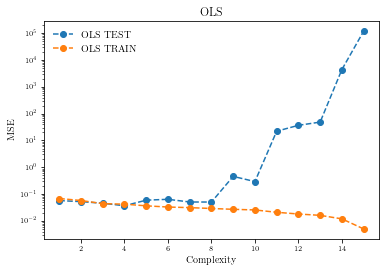

In [3]:
degrees = np.arange(1,max_degree+1)

plt.semilogy(degrees, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degrees, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.savefig(FIGPATH + "OLS_MSE_Bootstrap_Hastie_211_N_{n}.pdf")

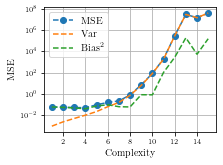

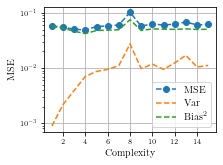

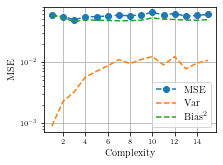

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ols_boot_variance,"--", label="Var")
plt.semilogy(degrees, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_OLS_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_Ridge_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(FIGPATH+f"Franke_LASSO_bootstrap_N_{n}.pdf")

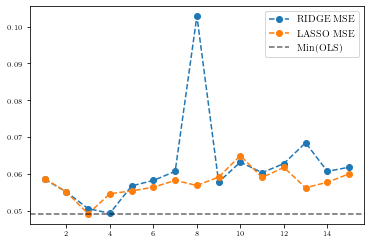

In [5]:
#plt.semilogy(degrees, ols_boot_mse,"o--",label="OLS MSE")
plt.plot(degrees, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.plot(degrees, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.axhline(np.min(lasso_best_lambda_boot_mse), color="black", alpha=0.6, ls="--", label="Min(OLS)")

plt.legend()

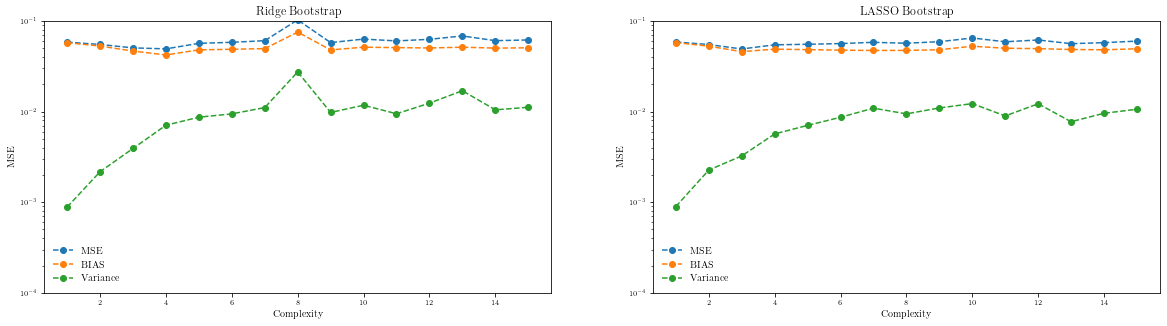

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

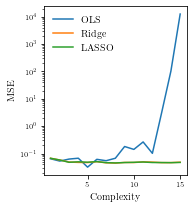

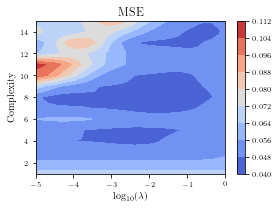

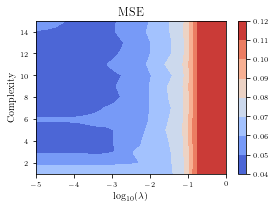

In [7]:
# CONTOUR PLOTS

plt.figure(figsize=FIGURESIZE*np.array([0.7, 1]))
#plt.axvline(degrees[np.argmin(ols_cv_mse)], ls="--", color="black", alpha=0.6)
plt.semilogy(degrees, ols_cv_mse, label="OLS")
plt.semilogy(degrees, best_ridge_mse, label="Ridge")
plt.semilogy(degrees, best_lasso_mse, label="LASSO")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(loc="best", frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH + f"OLS_CV_Franke_N_{n}.pdf")

# RIDGE
plt.figure(figsize=(4, 3) * np.array([1,1]))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, ridge_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"RIDGE_CV_Franke_contour_N_{n}.pdf")

# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, lasso_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"LASSO_CV_Franke_contour_N_{n}.pdf")

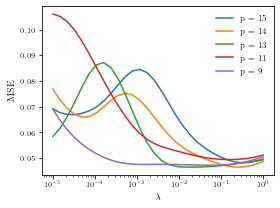

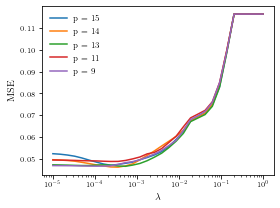

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"RIDGE_best_lambda_FRANKE_N_{n}.pdf")

# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"LASSO_best_lambda_FRANKE_N_{n}.pdf")

In [9]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 2.04335972e-01 4.17531894e-02 3.85662042e-03
 1.74332882e-03 8.53167852e-03 1.88739182e-02 4.89390092e-05
 6.21016942e-02 2.80721620e-02 1.37382380e-01 2.04335972e-01
 1.88739182e-02 3.03919538e-01 3.03919538e-01]
[1.74332882e-03 1.00000000e-05 3.56224789e-04 1.00000000e-05
 1.00000000e-05 4.89390092e-05 1.00000000e-05 1.08263673e-04
 1.08263673e-04 1.08263673e-04 2.39502662e-04 2.39502662e-04
 5.29831691e-04 3.56224789e-04 2.39502662e-04]


In [10]:
degree=5 # See how the best hyperparameters from CV-MSE above actually perform.
ridge_lambda=1e-2 # Ditto
lasso_lambda=1e-4 # Ditto
plot_grid_size=2000

np.random.seed(SEEDVAL)
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

# Setting up plotting grid
x_plot = np.linspace(0, 1, plot_grid_size)
y_plot = np.linspace(0, 1, plot_grid_size)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]

z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(plot_grid_size, -1)

# Ridge

betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(plot_grid_size, -1)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False, max_iter=10000).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(plot_grid_size, -1)


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16014556406546632, tolerance: 0.002324726067061767
  model = cd_fast.enet_coordinate_descent(


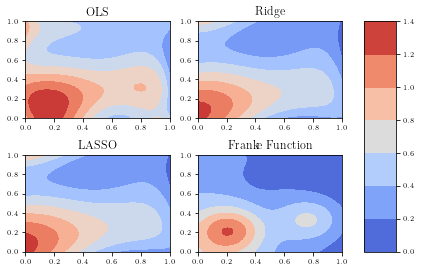

In [11]:
plt.subplot(221)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
plt.title("OLS")
plt.tight_layout()

plt.subplot(222)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
plt.title("Ridge")
plt.tight_layout()

plt.subplot(223)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
plt.title("LASSO")
plt.tight_layout()

plt.subplot(224)
plt.contourf(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)
plt.title("Franke Function")
plt.tight_layout()


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

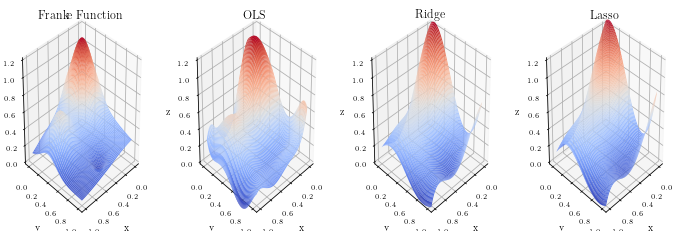

In [12]:
fig = plt.figure(figsize=(3 * 4,4))

# Plot the analytic curve
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])

surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
# Plot the Ridge
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
# Plot the Lasso
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
